In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize, dual_annealing, differential_evolution
from deap import base, creator, tools, algorithms

# Constants for the rocket
g0 = 9.81  # gravitational acceleration in m/s²
Isp = np.array([300, 350, 380])  # specific impulse for each stage (s)

# Input Parameters for the analysis
vf = 2000  # target/exhaust velocity (m/s) used in the equation formulation
beta = np.array([0.5, 0.3, 0.2])       # stage weight fractions
epsilon = np.array([0.15, 0.10, 0.06])   # structural mass fractions
alpha = np.array([0.98, 0.99, 1])        # stage efficiency factors

# List of solvers to try
solvers = ['newton', 'bisection', 'secant', 'scipy', 'genetic',
           'fixed_point', 'false_position', 'nelder_mead', 'powell', 'annealing', 'pso']

# Make sure the DEAP creator components are defined only once
if not hasattr(creator, "FitnessMin"):
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

def find_valid_bracket(f):
    a, b = 0, 1
    for _ in range(100):
        if f(a) * f(b) < 0:
            return a, b
        a /= 1.1
        b *= 1.1
    raise ValueError("Could not find a valid bracket.")

def Nstage(vf, beta, epsilon, alpha, solver='newton', tol=1e-9, max_iter=100):
    def f(p):
        p = np.clip(p, 1e-6, 1)
        return np.sum(beta * np.log(np.maximum(epsilon + alpha * (1 - epsilon) * p, 1e-9))) - vf

    def df(p):
        p = np.clip(p, 1e-6, 1)
        return np.sum(beta * (alpha * (1 - epsilon)) / np.maximum(epsilon + alpha * (1 - epsilon) * p, 1e-9))

    if solver == 'newton':
        p = 0.5
        for _ in range(max_iter):
            f_val, df_val = f(p), df(p)
            if abs(f_val) < tol:
                return p
            if abs(df_val) < 1e-12:
                return None
            p -= f_val / df_val
        return None
    
    elif solver == 'bisection':
        try:
            a, b = find_valid_bracket(f)
        except ValueError:
            return None
        for _ in range(max_iter):
            p = (a + b) / 2.0
            if abs(f(p)) < tol:
                return p
            if f(a) * f(p) < 0:
                b = p
            else:
                a = p
        return None
    
    elif solver == 'secant':
        p0, p1 = 0.1, 0.9
        for _ in range(max_iter):
            f0, f1 = f(p0), f(p1)
            if abs(f1) < tol:
                return p1
            if abs(f1 - f0) < 1e-12:
                return None
            p_new = p1 - f1 * (p1 - p0) / (f1 - f0)
            p0, p1 = p1, p_new
        return None
    
    elif solver == 'scipy':
        try:
            a, b = find_valid_bracket(f)
            sol = root_scalar(f, bracket=[a, b], method='brentq', xtol=tol)
            return sol.root if sol.converged else None
        except ValueError:
            return None
    
    elif solver == 'genetic':
        toolbox = base.Toolbox()
        toolbox.register("attr_float", np.random.uniform, 0, 1)
        toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=1)
        toolbox.register("population", tools.initRepeat, list, toolbox.individual)
        toolbox.register("evaluate", lambda ind: (abs(f(ind[0])),))
        toolbox.register("mate", tools.cxBlend, alpha=0.5)
        toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
        toolbox.register("select", tools.selTournament, tournsize=3)
    
        pop = toolbox.population(n=100)
        algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=False)
        return tools.selBest(pop, k=1)[0][0]
    
    elif solver == 'annealing':
        res = dual_annealing(lambda p: abs(f(p[0])), bounds=[(0, 1)])
        return res.x[0]
    
    elif solver == 'pso':
        res = differential_evolution(lambda p: abs(f(p[0])), bounds=[(0, 1)])
        return res.x[0]
    
    else:
        return None

In [42]:
# %% [code]
# Dictionary to store results from each solver
results = {}

for solver in solvers:
    start_time = time.time()
    try:
        p_opt = Nstage(vf, beta, epsilon, alpha, solver=solver)
        elapsed_time = time.time() - start_time
        if p_opt is not None:
            # Compute the per-stage delta-V contributions:
            # Each stage: ΔV_k = Isp_k * g0 * ln((epsilon_k + alpha_k*(1-epsilon_k)*p_opt) / epsilon_k)
            ratio = (epsilon + alpha * (1 - epsilon) * p_opt) / epsilon
            deltaV_stages = Isp * g0 * np.log(np.maximum(ratio, 1e-9))
            # Sum the contributions to get total delta-V
            total_deltaV = np.sum(deltaV_stages)
        else:
            deltaV_stages = None
            total_deltaV = None
        results[solver] = {
            'p_opt': p_opt,
            'deltaV': deltaV_stages,
            'total_deltaV': total_deltaV,
            'time': elapsed_time
        }
    except ValueError as e:
        results[solver] = {
            'p_opt': None,
            'deltaV': None,
            'total_deltaV': None,
            'time': None
        }
        print(f"Solver {solver} failed: {e}")

# Print the results in a clear format
for solver in solvers:
    res = results[solver]
    print(f"Solver: {solver}")
    print(f"  Optimal p: {res['p_opt']}")
    if res['deltaV'] is not None:
        print(f"  Delta-V (per stage): {res['deltaV']}")
        print(f"  Total Delta-V: {res['total_deltaV']} m/s")
    else:
        print("  Delta-V (per stage): None")
        print("  Total Delta-V: None")
    if res['time'] is not None:
        print(f"  Computation time: {res['time']:.4f} sec\n")
    else:
        print("  Computation time: N/A\n")


Solver newton failed: Newton's method did not converge.
Solver bisection failed: Invalid bracket.
Solver secant failed: Secant method failed.
Solver scipy failed: f(a) and f(b) must have different signs
Solver fixed_point failed: Fixed-point iteration did not converge.
Solver false_position failed: False Position method did not converge.
Solver pso failed: Invalid solver selection.
Solver: newton
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: N/A

Solver: bisection
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: N/A

Solver: secant
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: N/A

Solver: scipy
  Optimal p: None
  Delta-V (per stage): None
  Total Delta-V: None
  Computation time: N/A

Solver: genetic
  Optimal p: 1.2655201105940095
  Delta-V (per stage): [ 6130.02582212  8609.94264839 11318.44081182]
  Total Delta-V: 26058.409282336164 m/s
  Computation time: 0.1

C:\Users\User\AppData\Local\Temp\ipykernel_29304\3036492286.py:95: RuntimeWarning: overflow encountered in exp
  p_new = np.exp((vf - np.sum(beta * np.log(epsilon + alpha * (1 - epsilon) * p))) / np.sum(beta))
C:\Users\User\AppData\Local\Temp\ipykernel_29304\3036492286.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  p = (a * fb - b * fa) / (fb - fa)


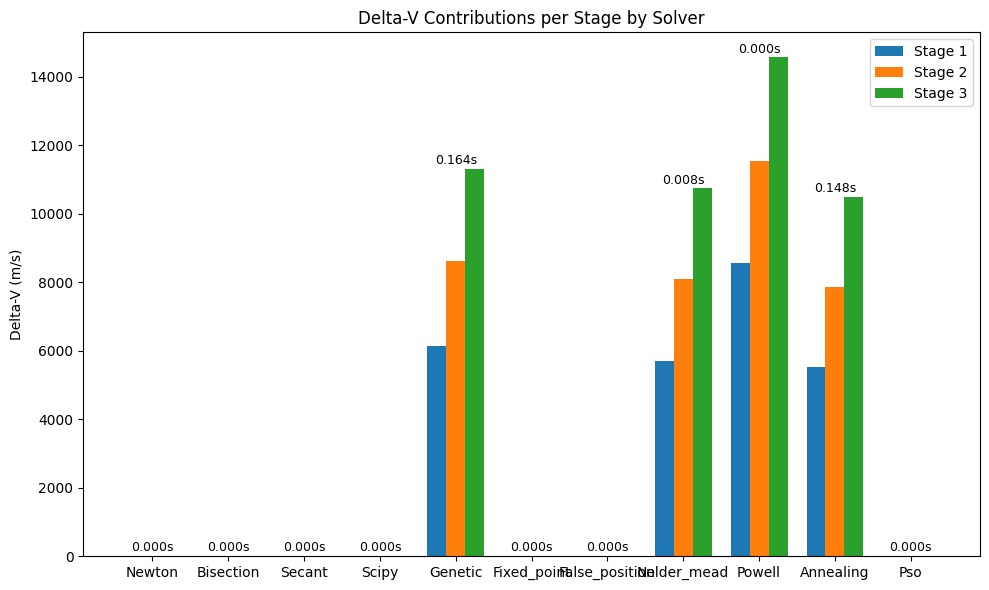

In [43]:
# %% [code]
# Prepare data for plotting
solver_names = []
stage1_dv = []
stage2_dv = []
stage3_dv = []
comp_times = []

for solver in solvers:
    solver_names.append(solver.capitalize())
    res = results[solver]
    if res['deltaV'] is not None:
        # Each deltaV is an array for the three stages.
        stage1_dv.append(res['deltaV'][0])
        stage2_dv.append(res['deltaV'][1])
        stage3_dv.append(res['deltaV'][2])
        comp_times.append(res['time'])
    else:
        stage1_dv.append(0)
        stage2_dv.append(0)
        stage3_dv.append(0)
        comp_times.append(0)

# Set up the bar width and positions
x = np.arange(len(solver_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, stage1_dv, width, label='Stage 1')
rects2 = ax.bar(x, stage2_dv, width, label='Stage 2')
rects3 = ax.bar(x + width, stage3_dv, width, label='Stage 3')

ax.set_ylabel('Delta-V (m/s)')
ax.set_title('Delta-V Contributions per Stage by Solver')
ax.set_xticks(x)
ax.set_xticklabels(solver_names)
ax.legend()

# Optionally annotate computation times above each group
for i, t in enumerate(comp_times):
    ax.text(x[i], max(stage1_dv[i], stage2_dv[i], stage3_dv[i]) + 50,
            f"{t:.3f}s", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()
